### Libraries

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

import numpy as np
from numpy import trace
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import mnist
import keras.backend as K
from keras.layers import Input, Dense, Lambda
from keras.layers import Flatten, Reshape
from keras.layers import BatchNormalization, Dropout
from PIL import Image as im
from numpy import cov
from numpy import asarray
from skimage.transform import resize
from itertools import chain
import random
from tensorflow.keras.optimizers import Adam
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse


### Dataset

In [ ]:
categories = {0: [],
              1: [],
              2: [],
              3: [],
              4: [],
              5: [],
              6: [],
              7: [],
              8: [],
              9: []}

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

for i in range(32):
    x_train = np.insert(x_train, len(x_train)-1, x_test[i], axis = 0)

x_train = x_train / 255

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
for i in range(32):
    y_train = np.insert(y_train, len(y_train)-1, y_test[i], axis = 0)

In [ ]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))

In [ ]:
print(x_train.shape)

(60032, 28, 28, 1)


In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()
######################################### If you are facing more errors

In [ ]:
for i in range(len(x_train)):
  categories[y_train[i]].append(x_train[i])

### VAE Components and Methods

In [ ]:
batch_size = 128
hidden_dim = 2 # Since we are in 2D space (images), the dimensions of mean and var are 2
n_epochs = 60

def dropout_and_batchnorm(x):
    return Dropout(0.3)(BatchNormalization()(x))

def prior(args):
    mean, log_var, batch_size, hidden_dim = args
    N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
    return K.exp(log_var / 2) * N + mean

In [ ]:
class VAE:
    def __init__(self, batch_size_, hidden_dim_, epochs_):
        self.batch_size = batch_size_
        self.hidden_dim = hidden_dim_
        self.epochs = epochs_
        self.input_image = Input(batch_shape=(self.batch_size, 28, 28, 1))
        self.encoder, self.latent_space = self.build_the_encoder()
        self.decoder = self.build_the_decoder()

    def build_the_encoder(self):
        x = Flatten()(self.input_image)
        x = Dense(256, activation="relu")(x)
        x = dropout_and_batchnorm(x)
        x = Dense(128, activation="relu")(x)
        x = dropout_and_batchnorm(x)
        # Our prior distribution is N(mean_of_batch, var_of_batch)
        self.mean = Dense(self.hidden_dim)(x)
        self.log_var = Dense(self.hidden_dim)(x)
        # print("K eval: ", K.eval(self.mean))
        # The latent space
        latent_space = Lambda(prior, output_shape=(self.hidden_dim))([self.mean, self.log_var, self.batch_size, self.hidden_dim])
        # The encoder built based on the latent space
        encoder = keras.Model(self.input_image, latent_space)
        return encoder, latent_space

    def build_the_decoder(self):
        input_decoder = Input(shape=(self.hidden_dim,))
        d = Dense(128, activation="relu")(input_decoder)
        d = dropout_and_batchnorm(d)
        d = Dense(256, activation="relu")(d)
        d = dropout_and_batchnorm(d)
        d = Dense(28*28, activation="sigmoid")(d)
        # The final layer
        decoded_image = Reshape((28, 28, 1))(d)
        decoder = keras.Model(input_decoder, decoded_image)
        return decoder

    def loss(self, main, reconstructed):
        main = K.reshape(main, shape=(self.batch_size, 28*28))
        reconstructed = K.reshape(reconstructed, shape=(self.batch_size, 28*28))
        reconstruction_loss = K.sum(K.square(main-reconstructed), axis=-1)
        kl_loss = -0.5 * K.sum(1 + self.log_var - K.square(self.mean) - K.exp(self.log_var), axis=-1)
        return reconstruction_loss + kl_loss

In [ ]:
vae = VAE(batch_size, hidden_dim, n_epochs)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
latent_sp = vae.encoder(vae.input_image)
model = keras.Model(vae.input_image, vae.decoder(latent_sp))
model.compile(optimizer= "adam", loss=vae.loss)

### Training the VAE

In [ ]:
import time
start_time = time.time()
model.fit(x_train, x_train, epochs=vae.epochs, batch_size = vae.batch_size, shuffle=True)
end_time = time.time()
exe_time = end_time - start_time

Train on 60032 samples
Epoch 1/60
60032/60032 [==============================] - 6s 107us/sample - loss: 81.2331
Epoch 2/60
60032/60032 [==============================] - 3s 49us/sample - loss: 50.4754
Epoch 3/60
60032/60032 [==============================] - 3s 46us/sample - loss: 46.7724
Epoch 4/60
60032/60032 [==============================] - 3s 47us/sample - loss: 45.1528
Epoch 5/60
60032/60032 [==============================] - 3s 47us/sample - loss: 44.3143
Epoch 6/60
60032/60032 [==============================] - 3s 46us/sample - loss: 43.6250
Epoch 7/60
60032/60032 [==============================] - 3s 47us/sample - loss: 43.1295
Epoch 8/60
60032/60032 [==============================] - 3s 47us/sample - loss: 42.6840
Epoch 9/60
60032/60032 [==============================] - 3s 46us/sample - loss: 42.4454
Epoch 10/60
60032/60032 [==============================] - 3s 46us/sample - loss: 42.2110
Epoch 11/60
60032/60032 [==============================] - 3s 46us/sample - loss: 41.

In [ ]:
print("Exec Time: ", exe_time)

Exec Time:  170.9655179977417


### Sampling from Latent Space

In [ ]:
latent_points = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
}

In [ ]:
def fill_latent_points(index):
    for i in range(0, len(categories[index]), batch_size):
        if i + batch_size >= len(categories[index]):
            break
        else:
            z_mean, z_log_var = K.function([vae.input_image], [vae.mean, vae.log_var])([np.asarray(categories[index])[i : i + batch_size]])
            if len(latent_points[index]) == 0:
                latent_points[index] = z_mean
            else:
                latent_points[index] = np.append(latent_points[index], z_mean, axis = 0)

In [ ]:
for t in range(10):
    fill_latent_points(t)

### Viewing GMMs on the Latent Space

In [ ]:
gmm_components = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
}

In [ ]:
number_of_gaussians = 3

In [ ]:
def plotting(points, title_, gmm_means, contour = [], label_idcs=None):
    # Creating a scatter plot
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(x=points[:, 0], y=points[:, 1], s=2.0,
                c=label_idcs, alpha=0.9, zorder=2)

    if len(gmm_means) > 0:
      ax.scatter(gmm_means[:, 0], gmm_means[:, 1], s=16.0,
                  alpha=0.9, zorder=2, color = 'r')

    if len(contour) > 0:
      for i in range(len(contour)):
          ax.add_patch(contour[i])

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
    plt.title(title_)
    plt.show()

In [ ]:
def get_ellipses(index):
    chi2_val = 5.91
    gmms = gmm_components[index]
    covariances = gmms.covariances_
    means = gmms.means_
    ellipse_covariances = []
    for i in range(len(covariances)):
        eigvals, eigvecs = np.linalg.eigh(covariances[i])
        angle = np.degrees(np.arctan2(*eigvecs[:, 1]))
        width, height = 2 * np.sqrt(eigvals * chi2_val)
        ellipse = Ellipse(means[i], width, height, angle, edgecolor='red', facecolor='none')
        ellipse_covariances.append(ellipse)
    return np.asarray(ellipse_covariances)

In [ ]:
def print_parameters_of_GMM(gmm):
    list_of_means = []
    list_of_covs = []
    for i in range(len(gmm.means_)):
        mean_i = gmm.means_[i]
        cov_i = gmm.covariances_[i]
        print('Mean of', i + 1, 'th component: \t\t' , mean_i)
        print('Covariance matrix of', i + 1, 'th component: \t', cov_i[0],'\n\t\t\t\t\t', cov_i[1])
        print('\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n')

In [ ]:
for current_label in range(10):
    gmm = GaussianMixture(n_components = number_of_gaussians,
                           covariance_type = 'full',
                           init_params = 'kmeans',
                           max_iter = 500,
                           )

    components = gmm.fit(latent_points[current_label])
    gmm_components[current_label] = components

<ipython-input-21-b53ce9389dd6>:11: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(means[i], width, height, angle, edgecolor='red', facecolor='none')


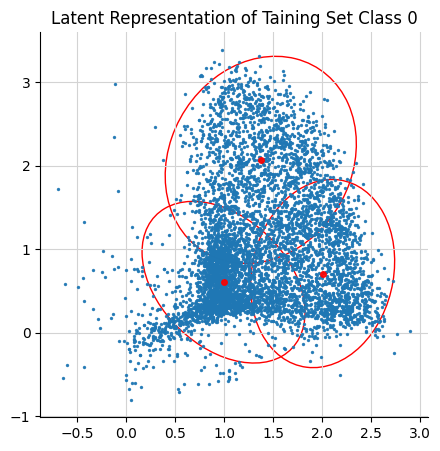

Mean of 1 th component: 		 [1.37512874 2.06840744]
Covariance matrix of 1 th component: 	 [ 0.16147255 -0.03177158] 
					 [-0.03177158  0.26032685]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 2 th component: 		 [0.99457243 0.60330624]
Covariance matrix of 2 th component: 	 [0.11739184 0.05106578] 
					 [0.05106578 0.15852459]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 3 th component: 		 [2.00734165 0.70707815]
Covariance matrix of 3 th component: 	 [ 0.0916983  -0.01835655] 
					 [-0.01835655  0.2148446 ]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



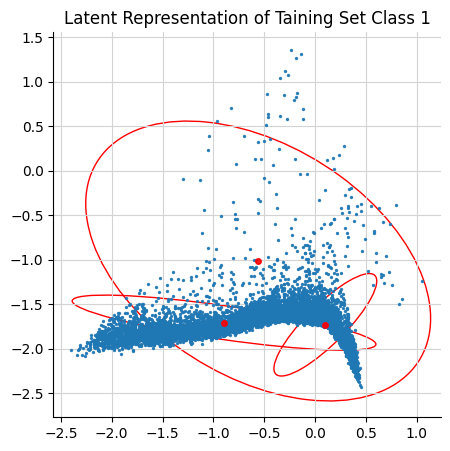

Mean of 1 th component: 		 [-0.55981751 -1.01480201]
Covariance matrix of 1 th component: 	 [0.48656882 0.18531139] 
					 [0.18531139 0.41881929]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 2 th component: 		 [-0.89533828 -1.70776181]
Covariance matrix of 2 th component: 	 [0.3772849  0.06142303] 
					 [0.06142303 0.01620969]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 3 th component: 		 [ 0.10068828 -1.7317805 ]
Covariance matrix of 3 th component: 	 [ 0.04328938 -0.04208322] 
					 [-0.04208322  0.05618509]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



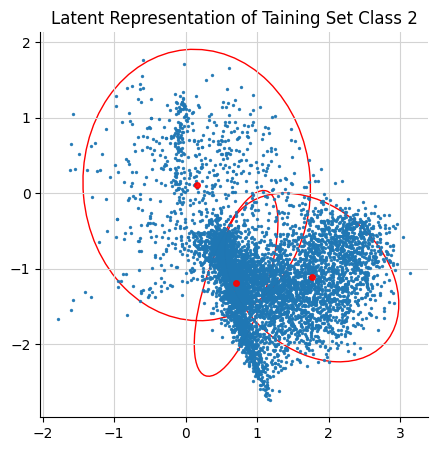

Mean of 1 th component: 		 [ 0.70721293 -1.19624623]
Covariance matrix of 1 th component: 	 [ 0.0578939  -0.08008408] 
					 [-0.08008408  0.25614795]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 2 th component: 		 [ 1.76689546 -1.11831369]
Covariance matrix of 2 th component: 	 [0.25028678 0.07228975] 
					 [0.07228975 0.21114588]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 3 th component: 		 [0.15622789 0.10686027]
Covariance matrix of 3 th component: 	 [0.4283039  0.01084328] 
					 [0.01084328 0.54665936]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



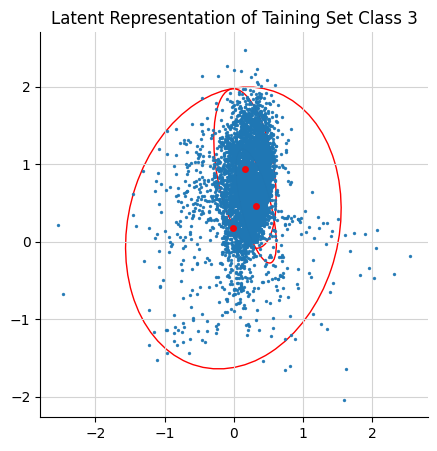

Mean of 1 th component: 		 [0.31960981 0.45936225]
Covariance matrix of 1 th component: 	 [0.01448363 0.02406262] 
					 [0.02406262 0.09157831]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 2 th component: 		 [0.15845395 0.94285619]
Covariance matrix of 2 th component: 	 [0.03430406 0.02879504] 
					 [0.02879504 0.17899171]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 3 th component: 		 [-0.00912768  0.17612635]
Covariance matrix of 3 th component: 	 [ 0.40989034 -0.06517287] 
					 [-0.06517287  0.559004  ]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



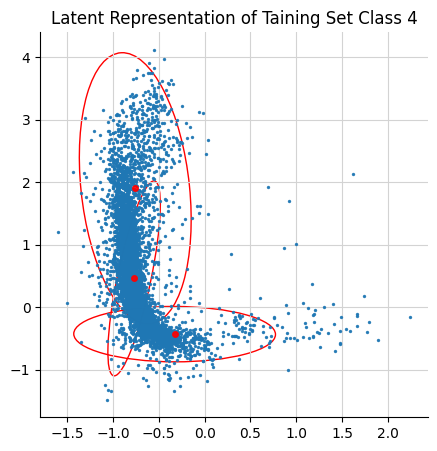

Mean of 1 th component: 		 [-0.76900906  0.46236977]
Covariance matrix of 1 th component: 	 [ 0.01385154 -0.05719412] 
					 [-0.05719412  0.41238062]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 2 th component: 		 [-0.32691728 -0.43107071]
Covariance matrix of 2 th component: 	 [0.20499737 0.00091412] 
					 [0.00091412 0.0332469 ]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 3 th component: 		 [-0.75648193  1.9046963 ]
Covariance matrix of 3 th component: 	 [0.06301286 0.05153513] 
					 [0.05153513 0.797379  ]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



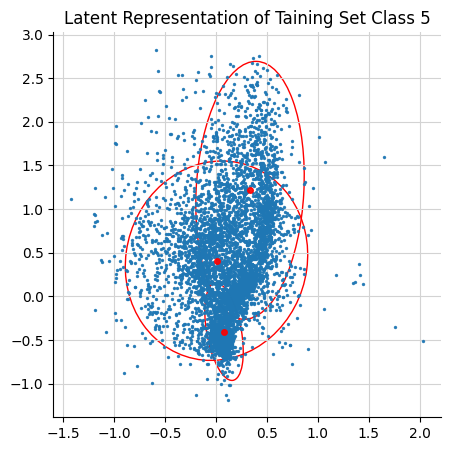

Mean of 1 th component: 		 [0.33339686 1.21546996]
Covariance matrix of 1 th component: 	 [ 0.04796837 -0.01450843] 
					 [-0.01450843  0.36909871]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 2 th component: 		 [0.00433919 0.40915918]
Covariance matrix of 2 th component: 	 [ 0.13574129 -0.01022807] 
					 [-0.01022807  0.22072823]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 3 th component: 		 [ 0.07831397 -0.4027888 ]
Covariance matrix of 3 th component: 	 [0.00603163 0.00733299] 
					 [0.00733299 0.05295684]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



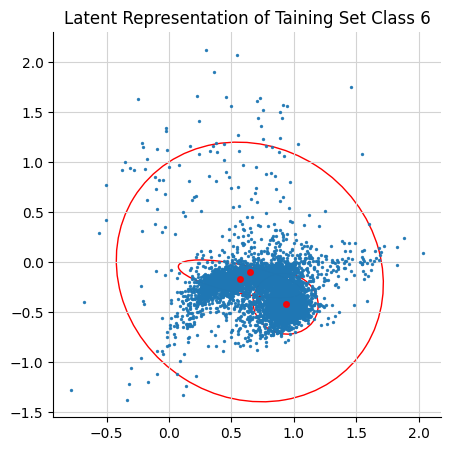

Mean of 1 th component: 		 [ 0.93430051 -0.41673301]
Covariance matrix of 1 th component: 	 [0.01147411 0.00075452] 
					 [0.00075452 0.0156697 ]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 2 th component: 		 [ 0.64747735 -0.09838061]
Covariance matrix of 2 th component: 	 [0.19337618 0.02145936] 
					 [0.02145936 0.28585937]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 3 th component: 		 [ 0.56876738 -0.16775583]
Covariance matrix of 3 th component: 	 [0.04121608 0.01025595] 
					 [0.01025595 0.00610071]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



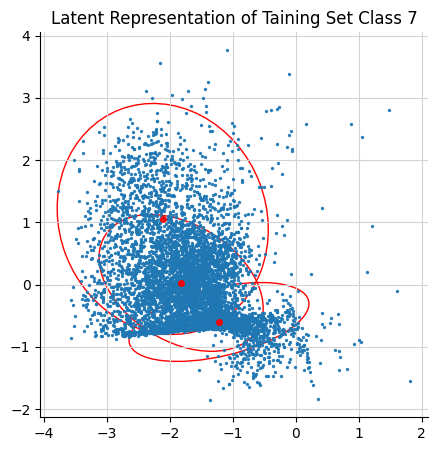

Mean of 1 th component: 		 [-1.82396598  0.02698307]
Covariance matrix of 1 th component: 	 [0.28763394 0.08975202] 
					 [0.08975202 0.20411008]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 2 th component: 		 [-1.22196731 -0.59989222]
Covariance matrix of 2 th component: 	 [ 0.34561724 -0.0707206 ] 
					 [-0.0707206   0.06797268]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 3 th component: 		 [-2.11574608  1.0546973 ]
Covariance matrix of 3 th component: 	 [0.47585234 0.0477987 ] 
					 [0.0477987  0.58242439]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



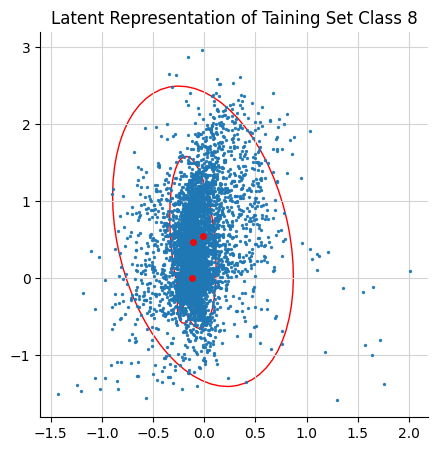

Mean of 1 th component: 		 [-0.12476679  0.00645617]
Covariance matrix of 1 th component: 	 [ 0.003233   -0.00771523] 
					 [-0.00771523  0.05839065]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 2 th component: 		 [-0.11133577  0.46573403]
Covariance matrix of 2 th component: 	 [0.00865758 0.01265812] 
					 [0.01265812 0.21040925]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 3 th component: 		 [-0.01276916  0.54588783]
Covariance matrix of 3 th component: 	 [0.13196545 0.07812917] 
					 [0.07812917 0.64241208]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



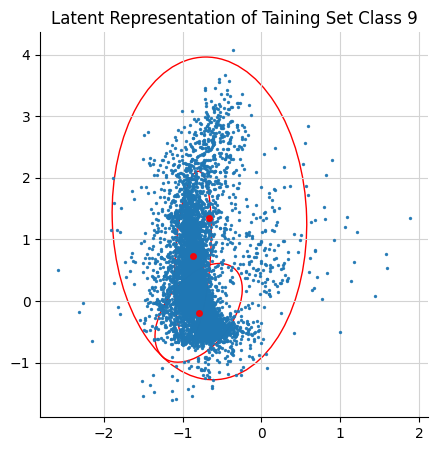

Mean of 1 th component: 		 [-0.65855744  1.34168937]
Covariance matrix of 1 th component: 	 [0.2575738  0.02000897] 
					 [0.02000897 1.15991187]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 2 th component: 		 [-0.79557514 -0.19057128]
Covariance matrix of 2 th component: 	 [ 0.0518193  -0.03578834] 
					 [-0.03578834  0.10862152]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Mean of 3 th component: 		 [-0.86818974  0.72419166]
Covariance matrix of 3 th component: 	 [ 0.00919622 -0.015782  ] 
					 [-0.015782    0.32310939]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



In [ ]:
for i in range(10):
    ellipses = get_ellipses(i)

    plotting(latent_points[i],
            title_ = "Latent Representation of Taining Set Class " + str(i),
                gmm_means=gmm_components[i].means_, contour = ellipses)

    print_parameters_of_GMM(gmm_components[i])

### Sampling from Latent Space for Decoder

In [ ]:
sampled_latent_points = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
}

In [ ]:
def sample_from_gmm(index):
    gmms = gmm_components[index]
    means = gmms.means_
    weights = gmms.weights_
    # print('Weights: ')
    # print(weights)
    covariances = gmms.covariances_
    num_samples = 1000
    sampled = []
    for i in range(len(weights)):
        standard_samples = np.random.multivariate_normal(means[i], covariances[i], int(num_samples * round(weights[i], 3)))
        if i == 0: sampled = standard_samples
        else:  sampled = np.append(sampled, standard_samples, axis = 0)
        # print(sampled.shape)
    # print(len(sampled))
    return np.asarray(sampled)

In [ ]:
for t in range(10):
    sampled_points = sample_from_gmm(t)
    # print(len(sampled_points))
    # print("For the ", t, "th label")
    # print(sampled_points.shape)
    # print(sampled_points[0])
    # print("\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n\n")
    sampled_latent_points[t] = sampled_points

<ipython-input-21-b53ce9389dd6>:11: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(means[i], width, height, angle, edgecolor='red', facecolor='none')


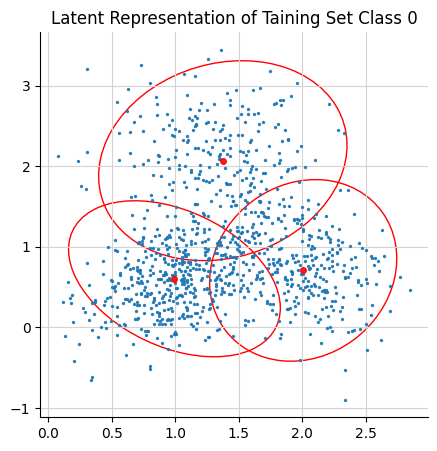

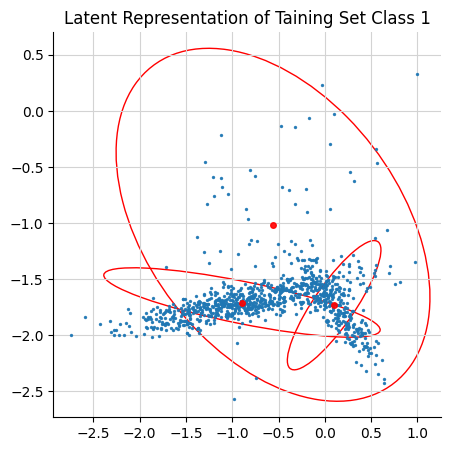

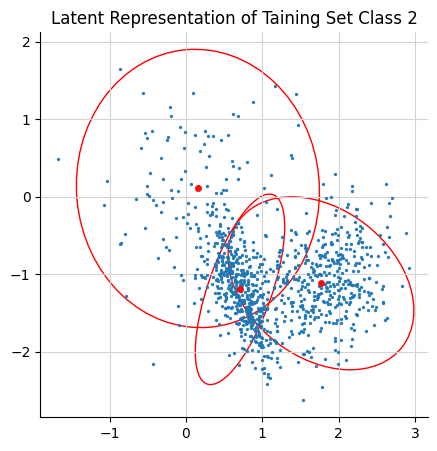

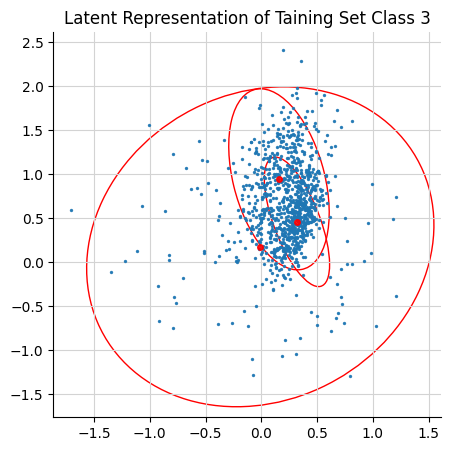

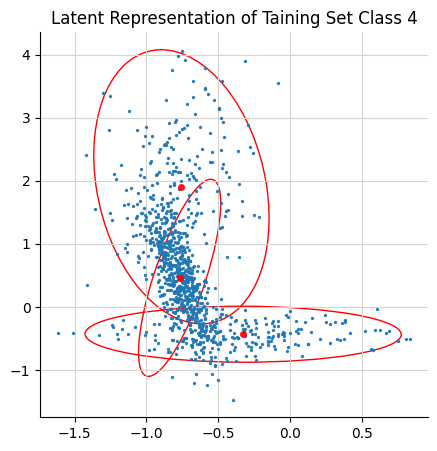

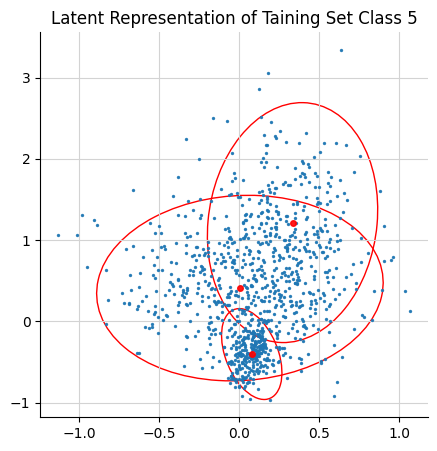

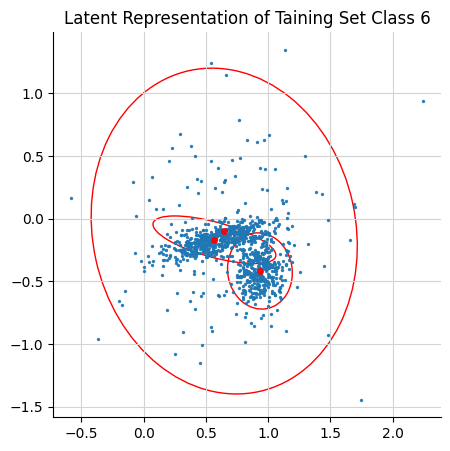

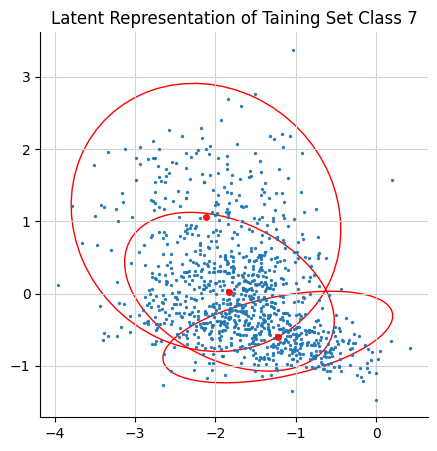

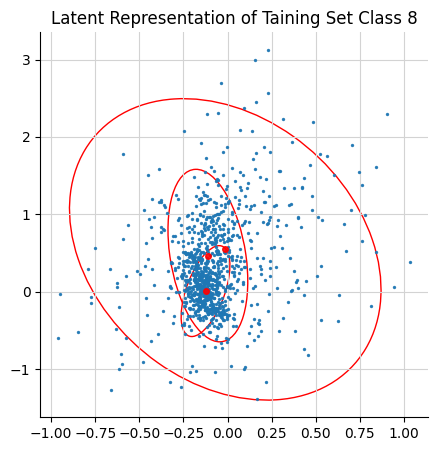

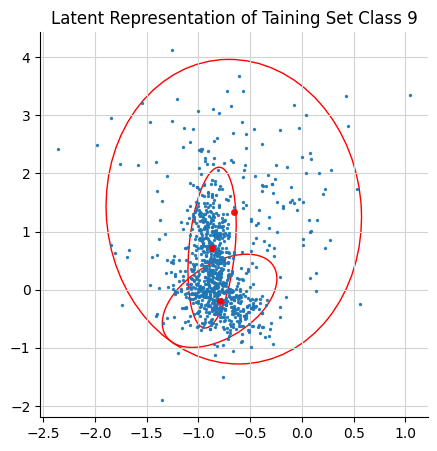

In [ ]:
for i in range(10):
  ellipses = get_ellipses(i)
  plotting(sampled_latent_points[i],
         title_ = "Latent Representation of Taining Set Class " + str(i), gmm_means=gmm_components[i].means_, contour = ellipses)

### FID Score (Pre-built)

In [ ]:
fid_score_list = []

In [ ]:
for i in range(10):
    for j in range(len(sampled_latent_points[i])):
          image = vae.decoder.predict(np.expand_dims(sampled_latent_points[i][j], axis=0))
          fid_score_list.append(image[0])

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
fid_score_list = np.asarray(fid_score_list)
print(fid_score_list.shape)
print(x_train.shape)

(10001, 28, 28, 1)
(60032, 28, 28, 1)


In [ ]:
from fid import FID_measure
import random
import gc

gc.collect()

71347

In [ ]:
fid = FID_measure(gen_images_ = fid_score_list, train_set_ = x_train, labels_ = y_train)
train_set_shrinked, train_set_shrinked_labels = fid.sample_uniformly()

Middle of Constructor
Train set len :  60032
End of Constructor
Middle of sample uniformly
Train set len :  10000
End of sample uniformly


In [ ]:
score = fid.calculate_fid()
print('FID: %.3f' % score)

beginning of calc_fid
gen_images len :  10001
Check whether shrink is not None
Train set len :  10000
87910968/87910968 [==============================] - 6s 0us/step
gen_images solved
train_set solved
sigma1 solved
sigma2 solved
FID: 24.690


### FID Score (Manual)

In [ ]:
def calc_mu_and_sigma(dataset):
    # The returned sigma is the covariance matrix and mu is the mean
    flatten_images = []

    for i in range(len(dataset)):
        vectorize = np.array(list(chain.from_iterable(dataset[i])))
        flatten_images.append(vectorize)

    flatten_images = np.array(flatten_images)
    print("Flatten images: ", flatten_images.shape)
    mu = flatten_images.mean(axis = 0)
    print("Mu: ", mu.shape)
    sigma = np.dot(flatten_images[0], flatten_images[0].T)

    print("Sigma: ", sigma.shape)

    for i in range(1, len(flatten_images)):
        Ui = np.dot(flatten_images[i], flatten_images[i].T)
        sigma += Ui

    mu_mu_T = np.dot(mu, mu.T)
    sigma = sigma / len(dataset)
    sigma = sigma - mu_mu_T

    return mu, sigma, flatten_images

In [ ]:
mu_train, sigma_train, vectorized_train = calc_mu_and_sigma(train_set_shrinked)

Flatten images:  (10000, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


In [ ]:
mu_gen, sigma_gen, vectorized_gen = calc_mu_and_sigma(fid_score_list)

Flatten images:  (10001, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


In [ ]:
from scipy.linalg import sqrtm

diff_mean = np.sum(np.square(mu_train - mu_gen))

dot_of_sigmas = np.dot(sigma_train, sigma_gen.T)

diff_cov = sigma_train + sigma_gen - 2*sqrtm(dot_of_sigmas)

print("FID score of VAE with ", n_epochs, " epochs and ", batch_size, " batch size:\n", round(np.absolute(diff_mean + trace(diff_cov)), 4))

FID score of VAE with  60  epochs and  128  batch size:
 22.7567


### CNN for Predicting Generated Images

In [ ]:
from keras.models import load_model
cnn = load_model('CNN.h5')

In [ ]:
preds_gen = cnn.predict(fid_score_list)
pred_labels_gen = np.argmax(preds_gen, axis=1)

In [ ]:
unique_elements, counts = np.unique(pred_labels_gen, return_counts=True)
frequency = dict(zip(unique_elements, counts))
print("Frequency of Elements: ")
print(frequency)

Frequency of Elements: 
{0: 1024, 1: 1222, 2: 866, 3: 1306, 4: 116, 5: 774, 6: 1066, 7: 1092, 8: 750, 9: 1785}


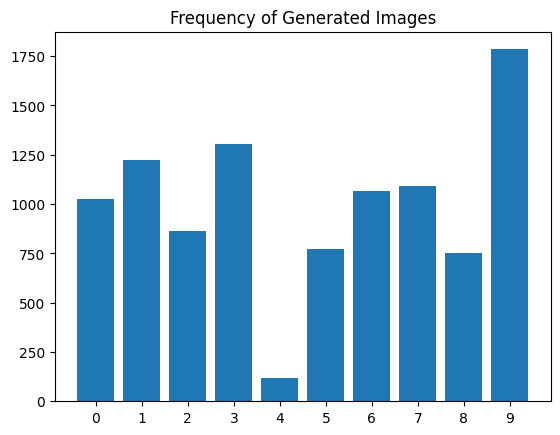

In [ ]:
plt.bar(unique_elements, counts)
plt.xticks(np.arange(10))
plt.title('Frequency of Generated Images')
plt.show()

### Viewing Dimension-Reduced Generated Images

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def scatter(first_axis, second_axis, labels, title):
    plt.figure(figsize=(10, 8))
    unique_classes = set(labels)
    plt.title(title)
    colors = ["red", "green", "blue", "yellow", "pink", "black", "orange", "purple", "cyan", "magenta"]
    for i, class_label in enumerate(unique_classes):
        class_indices = [j for j, c in enumerate(labels) if c == class_label]
        plt.scatter([first_axis[idx] for idx in class_indices],
                    [second_axis[idx] for idx in class_indices],
                    color=colors[i % len(colors)],
                    label=f'Class {class_label}')

    plt.legend()
    plt.show()


def map_diversity(data, variance_PCA):
    if data.ndim == 3:
        data = data.squeeze()
    pca = PCA(n_components = variance_PCA)
    reduced_vectors_pca = pca.fit_transform(data)
    # print(pca.n_components_) # If interested
    tsne = TSNE(n_components=2)
    reduced_vectors_tsne = tsne.fit_transform(reduced_vectors_pca)
    return reduced_vectors_tsne

In [ ]:
reduced_dimension_gen = map_diversity(data = vectorized_gen, variance_PCA = 0.85)

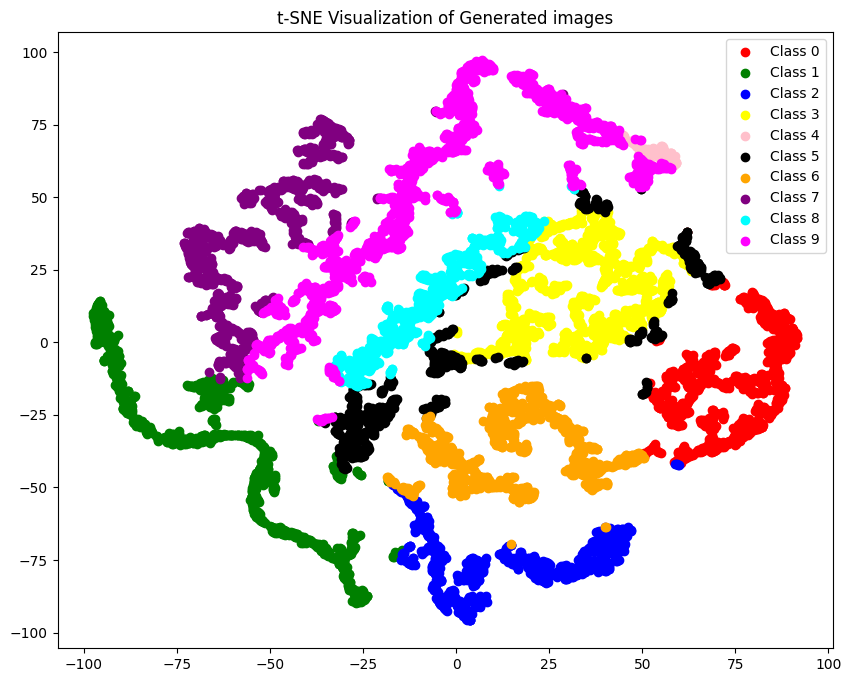

In [ ]:
scatter(reduced_dimension_gen[:, 0], reduced_dimension_gen[:, 1], pred_labels_gen, 't-SNE Visualization of Generated images')

In [ ]:
reduced_dimension_train = map_diversity(data = vectorized_train, variance_PCA = 0.85)

In [ ]:
preds_train = cnn.predict(train_set_shrinked)
pred_labels_train = np.argmax(preds_train, axis=1)

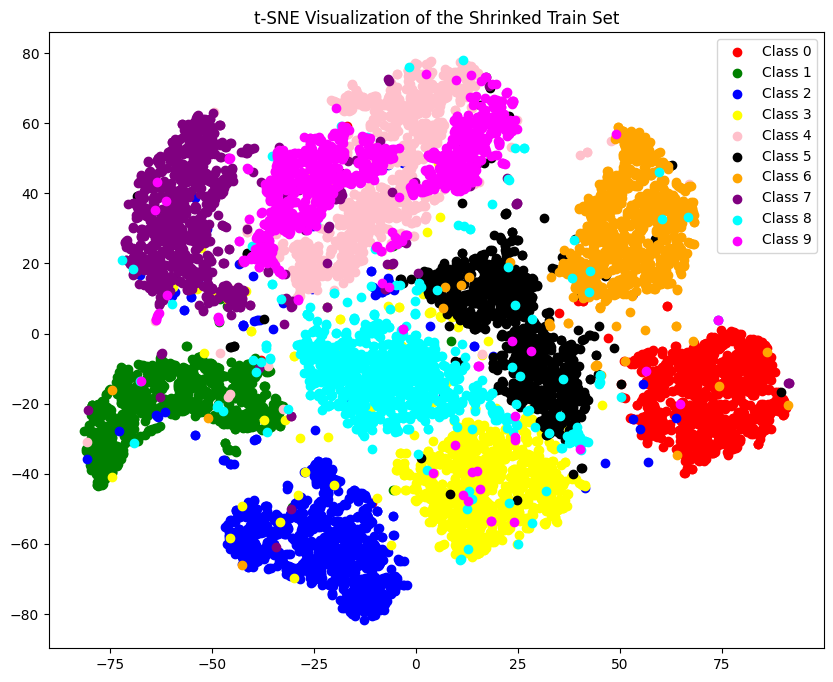

In [ ]:
scatter(reduced_dimension_train[:, 0], reduced_dimension_train[:, 1], pred_labels_train, 't-SNE Visualization of the Shrinked Train Set')

### Precision, Recall, Diversity, Coverage Metrics

In [ ]:
print(reduced_dimension_train.shape)
print(reduced_dimension_gen.shape)

(10000, 2)
(10001, 2)


In [ ]:
gc.collect()

25491

In [ ]:
!pip3 install prdc

from prdc import compute_prdc

In [ ]:
for j in np.asarray([5, 10, 6, 3, 2, 1]):
    print(j, "-Nearest Neighbors")
    metrics = compute_prdc(real_features = reduced_dimension_train,
                          fake_features = reduced_dimension_gen,
                          nearest_k=j)

    print(metrics)
    print("\n----------------------------------\n")

5 -Nearest Neighbors
Num real: 10000 Num fake: 10001
{'precision': 0.6988301169883012, 'recall': 0.3655, 'density': 0.5772822717728227, 'coverage': 0.3679}

----------------------------------

10 -Nearest Neighbors
Num real: 10000 Num fake: 10001
{'precision': 0.7406259374062594, 'recall': 0.5033, 'density': 0.5896410358964104, 'coverage': 0.4813}

----------------------------------

6 -Nearest Neighbors
Num real: 10000 Num fake: 10001
{'precision': 0.7161283871612839, 'recall': 0.3997, 'density': 0.5834416558344165, 'coverage': 0.3978}

----------------------------------

3 -Nearest Neighbors
Num real: 10000 Num fake: 10001
{'precision': 0.6123387661233877, 'recall': 0.2972, 'density': 0.5215478452154785, 'coverage': 0.2859}

----------------------------------

2 -Nearest Neighbors
Num real: 10000 Num fake: 10001
{'precision': 0.5155484451554845, 'recall': 0.2422, 'density': 0.4843015698430157, 'coverage': 0.2169}

----------------------------------

1 -Nearest Neighbors
Num real: 100